# Using pyTorch implementation

In this second part, we use pyTorch's implementation of RNNs and LSTMs. Again, as we are focusing on understanding the model and library, we will keep using the IMDB dataset. The good news is training is much faster using pyTorch's implementations.

## From dataset to batch inputs

You already know what to do here, it's the same as in the previous notebook.

In [1]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple
from collections import Counter, OrderedDict
from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

import copy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

C:\Users\junyi\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (C:/Users/junyi/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.99it/s]
Loading cached split indices for dataset at C:\Users\junyi\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-5f37fd0866e4f89f.arrow and C:\Users\junyi\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

### Vocabulary

In [3]:
unk_token = '<unk>'
pad_token = '<pad>'
tokenizer = get_tokenizer("basic_english", language="en")
corpus = train_df['text']
tokens = []
for text in corpus:
    tokens += tokenizer(text)
counter = Counter(tokens)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)
vocabulary = vocab(ordered_dict, specials=[unk_token, pad_token], min_freq = 5)
vocabulary.set_default_index(vocabulary[unk_token])

### Vectorize and batch the input

In [4]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    tokens = tokenizer(text)

    ids = [vocabulary[token] for token in tokens]

    tensor = torch.tensor(ids, dtype=torch.long)
    return tensor

In [5]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:06<00:00, 3724.33it/s]


### Data generation

In [6]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    n_batches = len(X) // batch_size
    if len(X) % batch_size != 0:
        n_batches += 1
    
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        batch_X = X[start_idx:end_idx]
        batch_y = y[start_idx:end_idx]

        # Padding the batch_X to the length of the longest element
        max_length = max([len(x) for x in batch_X])
        padded_X = []
        for x in batch_X:
            padding_length = max_length - len(x)
            padded_x = torch.nn.functional.pad(x, (0, padding_length), value=pad_id)
            padded_X.append(padded_x)
        
        yield torch.stack(padded_X), torch.tensor(batch_y)

train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

## The classifier

The implementation behind shows how to use the [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) implementation provided by pyTorch to code a simple RNN.

In [7]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Training (1 point)

**\[1 point\]** Code the training function.
* Note that we are using a function, as we will use it on several models here.
* The RNN implementation of pyTorch doesn't need to be manually looped. As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.

In [9]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model using batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returning a batch (data, labels).
        valid_gen: a callable function returning a batch (data, labels).
    Returns:
        A tuple: [best_model (by validation loss), training losses, validation losses].
    """
    best_loss = float('inf')
    best_model = None
    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0

        for X_train_batch, y_train_batch in train_gen():
            optimizer.zero_grad()

            # Forward pass
            output = model(X_train_batch).squeeze(-1)
            target = y_train_batch.float()
            loss = criterion(output, target)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= sum(1 for _ in train_gen())
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0

        with torch.no_grad():
            for X_valid_batch, y_valid_batch in valid_gen():
                output = model(X_valid_batch).squeeze(-1)
                target = y_valid_batch.float()
                loss = criterion(output, target)

                valid_loss += loss.item()

        valid_loss /= sum(1 for _ in valid_gen())
        valid_losses.append(valid_loss)

        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f}")

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_model = copy.deepcopy(model)

    return best_model, train_losses, valid_losses

In [10]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [11]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 1, train_gen, valid_gen)

Epoch 1/1 - Train Loss: 0.6951 - Valid Loss: 0.6931


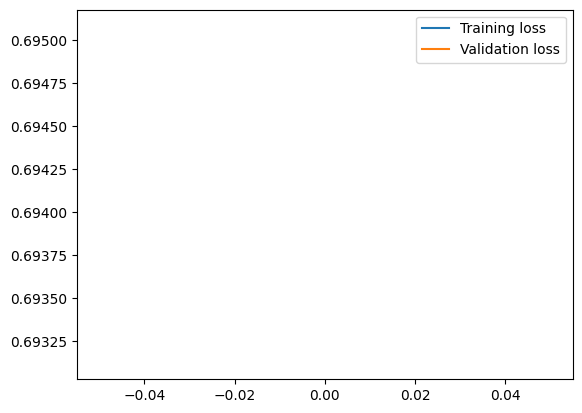

In [12]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

## Do the following (5 points)
* **\[1 point\]** Add an accuracy function and report the accuracy of the training, validation, and test set.
* **\[2 points\]** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
  * Look at the [LSTM documentation of pyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
* **\[1 point\]** Implement a function which takes any text and returns the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).
* **\[Bonus\]** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * **Beware of the behaviour of the output layer.** For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.
* **\[1 point\]** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **\[Bonus\]** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

### Accuracy

In [13]:
def compute_accuracy(model: nn.Module, data_gen: Callable) -> float:
    """Compute the accuracy of the model on a given dataset.
    Args:
        model: a trained model.
        data_gen: a callable function returning a batch (data, labels).
    Returns:
        The accuracy of the model on the dataset.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in data_gen():
            output = model(X_batch)
            predictions = torch.round(torch.sigmoid(output))  # Apply threshold at 0.5 for binary classification
            correct += (predictions.squeeze() == y_batch).sum().item()
            total += y_batch.size(0)

    accuracy = correct / total
    return accuracy

train_accuracy = compute_accuracy(best_model, train_gen)
valid_accuracy = compute_accuracy(best_model, valid_gen)
test_accuracy = compute_accuracy(best_model, test_gen)

print(f"Train Accuracy: {train_accuracy:.2%}")
print(f"Valid Accuracy: {valid_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")

Train Accuracy: 50.03%
Valid Accuracy: 49.72%
Test Accuracy: 49.90%


In [14]:
from sklearn.metrics import accuracy_score

# Evaluate the model on the training set
best_model.eval()
train_preds = []
train_targets = []

with torch.no_grad():
    for X, y in train_gen():
        output = best_model(X).squeeze(-1)
        preds = torch.round(torch.sigmoid(output))
        train_preds.extend(preds)
        train_targets.extend(y)

train_acc = accuracy_score(train_targets, train_preds)

# Evaluate the model on the validation set
best_model.eval()
valid_preds = []
valid_targets = []

with torch.no_grad():
    for X, y in valid_gen():
        output = best_model(X).squeeze(-1)
        preds = torch.round(torch.sigmoid(output))
        valid_preds.extend(preds)
        valid_targets.extend(y)

valid_acc = accuracy_score(valid_targets, valid_preds)

# Evaluate the model on the test set
best_model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for X, y in test_gen():
        output = best_model(X).squeeze(-1)
        preds = torch.round(torch.sigmoid(output))
        test_preds.extend(preds)
        test_targets.extend(y)

test_acc = accuracy_score(test_targets, test_preds)

print(f"Training accuracy: {train_acc}")
print(f"Validation accuracy: {valid_acc}")
print(f"Test accuracy: {test_acc}")

Training accuracy: 0.50035
Validation accuracy: 0.4968
Test accuracy: 0.49892


The accuracies are at 50% which means that a problem has occured.

In [15]:
class LSTM(nn.Module):
    """A simple LSTM module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The LSTM
        self.lstm = nn.LSTM(
            input_size=self.embed_size,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            batch_first=True,
        )
        # A fully connected layer to project the LSTM's output to the output dimension for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        out, _ = self.lstm(out, (h0, c0))
        out = out[:, -1, :]

        # Linear projection.
        out = self.fc(out)

        return out

In [16]:
# Instantiate the LSTM model
lstm_model = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)

# Train the LSTM model
lstm_best_model, lstm_train_losses, lstm_valid_losses = train(lstm_model, criterion, optimizer, 1, train_gen, valid_gen)

# Compute accuracies for the LSTM model
lstm_train_accuracy = compute_accuracy(lstm_best_model, train_gen)
lstm_valid_accuracy = compute_accuracy(lstm_best_model, valid_gen)
lstm_test_accuracy = compute_accuracy(lstm_best_model, test_gen)

Epoch 1/1 - Train Loss: 0.6939 - Valid Loss: 0.6939
LSTM Train Accuracy: 0.50%
LSTM Valid Accuracy: 0.50%
LSTM Test Accuracy: 0.50%


In [18]:
print(f"LSTM Train Accuracy: {lstm_train_accuracy:.2%}")
print(f"LSTM Valid Accuracy: {lstm_valid_accuracy:.2%}")
print(f"LSTM Test Accuracy: {lstm_test_accuracy:.2%}")

LSTM Train Accuracy: 50.04%
LSTM Valid Accuracy: 50.42%
LSTM Test Accuracy: 49.94%


Same here, we have accuracies at 50%.